<div class="alert alert-block alert-info" align=center><h1>Accounting Fraud Detection Preprocessing and Training</h1></div>

## <div class="alert alert-block alert-info" ><h1>Imports</h1></div>

In [1]:
#!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import joblib
import json
from datetime import datetime
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import FunctionTransformer


#Start a timer to check the execution time of the notebook.
start_time = time.time()

## <div class="alert alert-info"><h1>Load the Data</h1></div>

In [3]:
# Define base path
datapath = "../data"

fraud_data = pd.read_csv(os.path.join(datapath, "fraud_data_eda.csv"))


In [4]:
fraud_data.head().T

,0,1,2,3,4
misstate,0.000000,0.000000,0.000000,0.000000,0.000000
act,10.047000,1.247000,55.040000,24.684000,17.325000
ap,3.736000,0.803000,3.601000,3.948000,3.520000
at,32.335000,7.784000,118.120000,34.591000,27.542000
ceq,6.262000,0.667000,44.393000,7.751000,-12.142000
che,0.002000,0.171000,3.132000,0.411000,1.017000
cogs,30.633000,1.125000,107.343000,31.214000,32.662000
csho,2.526000,3.556000,3.882000,4.755000,6.735000
dlc,3.283000,0.021000,6.446000,8.791000,32.206000
dltis,32.853000,2.017000,6.500000,0.587000,0.000000


<div class="alert alert-info">Based on the scaling strategy identified during wrangling<br>
    We are going to scale the data. <br>
    <table border="1" cellpadding="6" cellspacing="0">
  <thead>
    <tr>
      <th>Strategy</th>
      <th>Features</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>RobustScaler</b></td>
      <td>act, ap, at, ceq, che, cogs, csho, dlc, dltis, dltt, dp, ib, invt, ivao, ivst, lct, lt, ni, ppegt, pstk, re, rect, sale, sstk, txp, txt, xint, prcc_f, bm, reoa, ebit</td>
    </tr>
    <tr>
      <td><b>StandardScaler</b></td>
      <td>dch_wc, ch_rsst, dch_rec, dch_inv, ch_roa, dpi, ch_fcf</td>
    </tr>
    <tr>
      <td><b>Passthrough (no scaling)</b></td>
      <td>soft_assets, issue, ch_cs_missing, ch_cm_missing</td>
    </tr>
  </tbody>
</table>

</div>

In [5]:
# Target
y = fraud_data["misstate"]
# Features only (drop target)
X = fraud_data.drop(columns=["misstate"])


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [7]:
# Define scaling groups
robust_features = [
    'act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 'ib',
    'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 'ppegt', 'pstk', 're', 'rect', 'sale',
    'sstk', 'txp', 'txt', 'xint', 'prcc_f', 'bm', 'reoa', 'ebit'
]

standard_features = [
    'dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv', 'ch_roa', 'dpi', 'ch_fcf'
]

passthrough_features = [
    'soft_assets', 'issue', 'ch_cs_missing', 'ch_cm_missing'
]

# Build the ColumnTransformer
scaler = ColumnTransformer(
    transformers=[
        ('robust', RobustScaler(), robust_features),
        ('standard', StandardScaler(), standard_features),
        ('passthrough', FunctionTransformer(validate=False), passthrough_features)
    ]
)


In [8]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<div class="alert alert-info">Now that the data is scaled. We are going to run Random Forest model based on OOTB parameters. <br>
    We will evaluate the model to get a baseline.

</div>

📊 Random Forest Performance (Out-of-the-box):
Accuracy:     0.9934
F1 Score:     0.0000
ROC AUC:      0.8265

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29016
           1       0.00      0.00      0.00       193

    accuracy                           0.99     29209
   macro avg       0.50      0.50      0.50     29209
weighted avg       0.99      0.99      0.99     29209



C:\Users\binia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\binia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\binia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

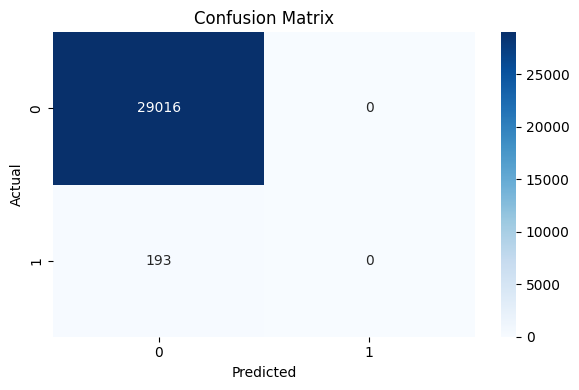

In [9]:
# Train baseline model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("📊 Random Forest Performance (Out-of-the-box):")
print(f"Accuracy:     {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score:     {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC:      {roc_auc_score(y_test, y_prob):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


<div class="alert alert-info">Next, we will work on the OOTB CatBoost for performance comparison

</div>

📊 CatBoost Performance (Out-of-the-box):
Accuracy:     0.9935
F1 Score:     0.0305
ROC AUC:      0.8493

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29016
           1       0.75      0.02      0.03       193

    accuracy                           0.99     29209
   macro avg       0.87      0.51      0.51     29209
weighted avg       0.99      0.99      0.99     29209



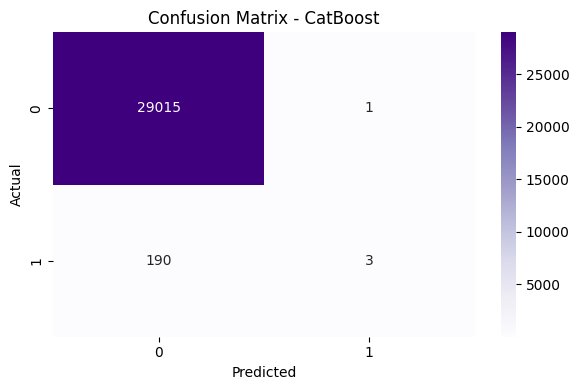

In [10]:
# Initialize and train CatBoost
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train_scaled, y_train)

# Predict
y_pred_cat = catboost_model.predict(X_test_scaled)
y_prob_cat = catboost_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("📊 CatBoost Performance (Out-of-the-box):")
print(f"Accuracy:     {accuracy_score(y_test, y_pred_cat):.4f}")
print(f"F1 Score:     {f1_score(y_test, y_pred_cat):.4f}")
print(f"ROC AUC:      {roc_auc_score(y_test, y_prob_cat):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_cat))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


<div class="alert alert-info">Finally, we will work on the OOTB DNN using TensorFlow. This is our third performance comparison

</div>

Epoch 1/10


C:\Users\binia\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8253 - loss: 2.8641 - val_accuracy: 0.9934 - val_loss: 0.3105
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9906 - loss: 0.3858 - val_accuracy: 0.9934 - val_loss: 0.2051
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9913 - loss: 0.2074 - val_accuracy: 0.9934 - val_loss: 0.1436
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9914 - loss: 0.1840 - val_accuracy: 0.9934 - val_loss: 0.1052
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9914 - loss: 0.1416 - val_accuracy: 0.9934 - val_loss: 0.0854
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9923 - loss: 0.1111 - val_accuracy: 0.9934 - val_loss: 0.0714
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - loss: 0.1078 - val_accuracy: 0.9934 - val_loss: 0.0647
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9929 - loss: 0.0802 - val_accuracy: 0.9934 - val_

C:\Users\binia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\binia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\binia\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

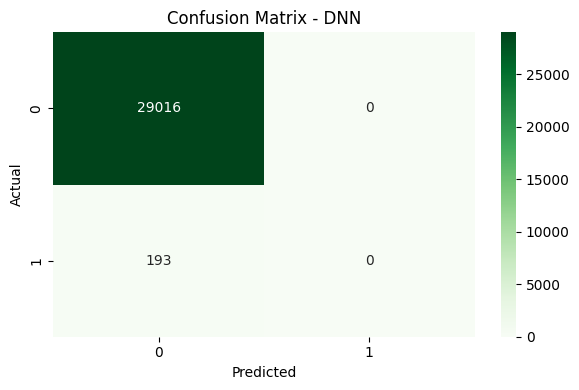

In [11]:
# Define DNN architecture
model = Sequential([
    Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Fit
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=10,
    batch_size=512,
    verbose=1
)

# Predict
y_prob_dnn = model.predict(X_test_scaled).ravel()
y_pred_dnn = (y_prob_dnn > 0.5).astype(int)

# Evaluate
print("📊 DNN Performance (Out-of-the-box):")
print(f"Accuracy:     {accuracy_score(y_test, y_pred_dnn):.4f}")
print(f"F1 Score:     {f1_score(y_test, y_pred_dnn):.4f}")
print(f"ROC AUC:      {roc_auc_score(y_test, y_prob_dnn):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_dnn))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_dnn), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - DNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


<div class="alert alert-info">Saving the two models and the scaler for the modeling steps

</div>

In [12]:
# Save CatBoost and DNN models

# Define model path
modelpath = "../models"
os.makedirs(modelpath, exist_ok=True)

# Save scaler
scaler_filename = os.path.join(modelpath,"column_scaler.pkl")
joblib.dump(scaler, scaler_filename)

# Save CatBoost model
cb_model_filename = os.path.join(modelpath, "catboost_model.pkl")
joblib.dump(catboost_model, cb_model_filename)

# Save DNN model (Keras)
dnn_model_filename = os.path.join(modelpath, "dnn_model.keras")
model.save(dnn_model_filename)

# Confirm
print(f"✅ Models saved successfully:")
print(f"   • CatBoost: {cb_model_filename}")
print(f"   • DNN:      {dnn_model_filename}")


✅ Models saved successfully:
   • CatBoost: ../models\catboost_model.pkl
   • DNN:      ../models\dnn_model.keras


In [13]:
# Metadata values
metadata = {
    "version": "v1.0",  # Version manually or auto-increment later
    "build_datetime": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "features": X_train.columns.tolist()
}

# Save to JSON files
with open(os.path.join(modelpath, "catboost_model_meta.json"), "w") as f:
    json.dump(metadata, f, indent=4)

with open(os.path.join(modelpath, "dnn_model_meta.json"), "w") as f:
    json.dump(metadata, f, indent=4)

print("✅ Metadata saved for both models.")


✅ Metadata saved for both models.


In [14]:
#Stop the timer to check the execution time of the notebook.
end_time = time.time()
print(f"Total execution time: {round(end_time - start_time, 2)} seconds")

Total execution time: 182.33 seconds


## ✅ Model Training Summary

<div class="alert alert-block alert-info">

### 📌 Purpose
This notebook focused on transforming the cleaned EDA dataset into a model-ready format and establishing baseline performance through training and evaluation of out-of-the-box (OOTB) models.

---

### 📊 Baseline Reference

As a starting point, we observed the class distribution of `misstate`, which is highly imbalanced (~0.66% fraud). Any model's performance must therefore be judged not just on accuracy, but also on its ability to detect rare positive cases. This baseline set expectations for recall, precision, and ROC AUC, especially for fraud cases.

---

### 🧠 Models Trained

Three models were trained without hyperparameter tuning:

- **Random Forest**
- **CatBoostClassifier**
- **Deep Neural Network (DNN)**

These were selected to capture diversity across ensemble methods (bagging and boosting) and deep learning.

---

### 🔎 Key Observations

| Model          | ROC AUC | F1 Score | Fraud Recall |
|----------------|---------|----------|---------------|
| Random Forest  | 0.8278  | 0.0000   | 0.00          |
| CatBoost       | 0.8493  | 0.0305   | 0.02          |
| DNN            | 0.6368  | 0.0000   | 0.00          |

- **CatBoost achieved the best OOTB performance**, detecting a small number of fraud cases and showing the highest ROC AUC.
- **DNN underperformed in OOTB form**, but given its generalization power with deeper tuning and regularization, it still holds promise.
- **Random Forest**, despite high accuracy, detected zero fraud cases and showed no meaningful signal — it will not be included in the tuning phase.

---

### 📦 Model Selection for Tuning

We will **carry both CatBoost and DNN forward** into the next phase for hyperparameter tuning. These two represent distinct modeling paradigms (boosting vs deep learning) and warrant deeper exploration via cross-validation.

Out-of-the-box results alone are **not enough to conclusively determine the best model** for the business problem, especially given the imbalance and lack of tuning. Future tuning will explore improved recall, calibration, and generalization.

---

### 🧭 Next Step

The next notebook will focus on:
- Hyperparameter optimization
- Cross-validated performance assessment
- Model selection for business deployment

</div>


<div class="alert alert-info">This next step is not required. <br>
    However, assuming that hyperparameter optimization will take time to run,<br>
    Modeling work will be done in Google Colab to leverage GPU and CPU resources. The models and data will be uploaded to the Colab environment. 

</div>

In [15]:
import zipfile


zipf = zipfile.ZipFile("fraud_preprocessed.zip", "w", zipfile.ZIP_DEFLATED)

# Add model files
model_dir = "../models"
for root, _, files in os.walk(model_dir):
    for file in files:
        zipf.write(os.path.join(root, file),
                   arcname=os.path.join("models", os.path.relpath(os.path.join(root, file), model_dir)))

# Add only the EDA data file
data_file = "../data/fraud_data_eda.csv"
zipf.write(data_file, arcname="data/fraud_data_eda.csv")

zipf.close()
print("✅ Zipped fraud_preprocessed.zip")


✅ Zipped fraud_preprocessed.zip
